In [5]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy
import os
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision

from torchsummary import summary


In [15]:
class CIFAR:
    """
    CIFAR-10 Dataset Loader with Augmentations and Proper Formatting.
    """

    def __init__(self, batch_size=128, num_workers=4):
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_loader, self.test_loader = self.prepare_data()

    def prepare_data(self):
        """
        Prepare train and test data loaders with transformations.
        """
        
        # Advanced Data Augmentation for Better Generalization
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),      
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            AutoAugment(AutoAugmentPolicy.CIFAR10),  # AutoAugment (Strong Augmentation)
            transforms.ToTensor(),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
        ])

        trainset = torchvision.datasets.CIFAR10(
            root="./data", train=True, download=True, transform=transform_train
        )
        trainloader = DataLoader(
            trainset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )

        testset = torchvision.datasets.CIFAR10(
            root="./data", train=False, download=True, transform=transform_test
        )
        testloader = DataLoader(
            testset, batch_size=100, shuffle=False, num_workers=self.num_workers, pin_memory=True
        )

        return trainloader, testloader

train_loss_history = []
test_loss_history = []
accuracy_history = []


def train_model(model, cifar_data, lr=0.05, epochs=200, device="cuda", use_cutmix=True, use_mixup=True):
    """
    Train and Evaluate Model with Augmentations, LR Scheduling, and Mixed Precision.
    """
    model = model.to(device)
    if device == "cuda":
        model = torch.nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=2e-2)
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(cifar_data.train_loader), epochs=epochs)


    scaler = torch.cuda.amp.GradScaler()

    best_acc = 0

    for epoch in range(epochs):
        print(f"\nEpoch: {epoch+1}/{epochs}")
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        with tqdm(total=len(cifar_data.train_loader), desc=f"Train Epoch {epoch+1}") as pbar:
            for batch_idx, (inputs, targets) in enumerate(cifar_data.train_loader):
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()

                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                pbar.set_postfix({"Loss": f"{train_loss/(batch_idx+1):.3f}", 
                                  "Acc": f"{100.0 * correct / total:.3f}%"})
                pbar.update(1)

        model.eval()
        correct = 0
        total = 0
        test_loss = 0
        with torch.no_grad():
            with tqdm(total=len(cifar_data.test_loader), desc=f"Test Epoch {epoch+1}") as pbar:
                for batch_idx, (inputs, targets) in enumerate(cifar_data.test_loader):
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss+=loss.item()
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
                    pbar.update(1)


        acc = 100.0 * correct / total
        print(f"Test Accuracy: {acc:.3f}%")

        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        accuracy_history.append(acc)

        if acc > best_acc:
            print(f"Saving best model with accuracy: {acc:.3f}%")
            torch.save(model.state_dict(), "./best_model_hpc.pth")
            best_acc = acc

        scheduler.step()

    return best_acc

In [16]:
DATA_DIR='./data'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Function to initialize weights for layers
# Uses Kaiming Normal initialization for Convolutional and Linear layers
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

# Residual connection with optional shortcut and learnable scaling factor
class Residual(nn.Module):
    def __init__(self, residual, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = residual
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

# Normalization and activation block using BatchNorm and SiLU activation
class NormAct(nn.Sequential):
    def __init__(self, channels):
        super().__init__(
            nn.BatchNorm2d(channels),
            nn.SiLU(inplace=True)
        )

# Standard convolutional block with normalization and activation
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            NormAct(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups),
        )

# Squeeze-and-Excite block for channel-wise attention
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduced_channels):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(reduced_channels, channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return x * self.se(x)

# MBConv Residual Block: EfficientNet's main building block
class MBConvResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, expansion, kernel_size=3, stride=1):
        mid_channels = in_channels * expansion
        squeeze_channels = in_channels // 4
        super().__init__(
            ConvBlock(in_channels, mid_channels, 1), # Pointwise
            ConvBlock(mid_channels, mid_channels, kernel_size, stride=stride, groups=mid_channels), # Depthwise
            NormAct(mid_channels),
            SqueezeExciteBlock(mid_channels, squeeze_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1) # Pointwise
        )

# MBConv Block with Residual connection
class MBConvBlock(Residual):
    def __init__(self, in_channels, out_channels, expansion, kernel_size=3, stride=1):
        residual = MBConvResidual(in_channels, out_channels, expansion, kernel_size, stride)
        shortcut = self.get_shortcut(in_channels, out_channels, stride)
        super().__init__(residual, shortcut)
    
    def get_shortcut(self, in_channels, out_channels, stride):
        if in_channels != out_channels:
            shortcut = nn.Conv2d(in_channels, out_channels, 1)
            if stride > 1:
                shortcut = nn.Sequential(nn.AvgPool2d(stride), shortcut)
        elif stride > 1:
            shortcut = nn.AvgPool2d(stride)
        else:
            shortcut = nn.Identity()
        return shortcut

# Stack of multiple MBConv blocks
class BlockStack(nn.Sequential):
    def __init__(self, num_layers, channel_list, strides, expansion=4, kernel_size=3):
        layers = []
        for num, in_channels, out_channels, stride in zip(num_layers, channel_list, channel_list[1:], strides):
            for _ in range(num):
                layers.append(MBConvBlock(in_channels, out_channels, expansion, kernel_size, stride))
                in_channels = out_channels
                stride = 1
        super().__init__(*layers)

# Head of the network with classification layer
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, mult=4, p_drop=0.):
        mid_channels = in_channels * mult
        super().__init__(
            ConvBlock(in_channels, mid_channels, 1),
            NormAct(mid_channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(mid_channels, classes)
        )

# Initial convolutional layer (Stem) of EfficientNet
class Stem(nn.Sequential):
    def __init__(self, in_channels, mid_channels, out_channels, stride):
        squeeze_channels = mid_channels // 4
        super().__init__(
            nn.Conv2d(in_channels, mid_channels, 3, stride=stride, padding=1),
            ConvBlock(mid_channels, mid_channels, 3, groups=mid_channels), # Depthwise
            NormAct(mid_channels),
            SqueezeExciteBlock(mid_channels, squeeze_channels),
            nn.Conv2d(mid_channels, out_channels, kernel_size=1) # Pointwise
        )

# Full EfficientNet Model
class EfficientNet(nn.Sequential):
    def __init__(self, classes,  num_layers, channel_list, strides, expansion=4,
                 in_channels=3, head_p_drop=0.):
        super().__init__(
            Stem(in_channels, *channel_list[:2], stride=strides[0]),
            BlockStack(num_layers, channel_list[1:], strides[1:], expansion),
            Head(channel_list[-1], classes, p_drop=head_p_drop)
        )

# Create an EfficientNet model instance
model = EfficientNet(10,
                     num_layers = [5,  4,   4,   5],
                     channel_list = [32, 16, 32, 64, 128, 256],
                     strides = [1,  1,  2,   2,   2],
                     expansion = 5,
                     head_p_drop = 0.4)

# Apply weight initialization function to the model
model.apply(init_linear)
model.to(device)

print("Model Initialized!")

Model Initialized!


In [17]:
cifar_data = CIFAR(batch_size=128)

best_acc = train_model(
  model, cifar_data, lr=0.05, epochs=300, device=device
)

print(f"Training complete. Best accuracy achieved: {best_acc:.3f}%")

Files already downloaded and verified
Files already downloaded and verified

Epoch: 1/300


Test Epoch 1: 100%|██████████| 100/100 [00:01<00:00, 52.22it/s]


Test Accuracy: 49.510%
Saving best model with accuracy: 49.510%

Epoch: 2/300


Test Epoch 2: 100%|██████████| 100/100 [00:01<00:00, 60.72it/s]


Test Accuracy: 61.510%
Saving best model with accuracy: 61.510%

Epoch: 3/300


Test Epoch 3: 100%|██████████| 100/100 [00:01<00:00, 60.87it/s]


Test Accuracy: 68.410%
Saving best model with accuracy: 68.410%

Epoch: 4/300


Test Epoch 4: 100%|██████████| 100/100 [00:01<00:00, 57.50it/s]


Test Accuracy: 72.560%
Saving best model with accuracy: 72.560%

Epoch: 5/300


Test Epoch 5: 100%|██████████| 100/100 [00:01<00:00, 53.53it/s]


Test Accuracy: 76.800%
Saving best model with accuracy: 76.800%

Epoch: 6/300


Test Epoch 6: 100%|██████████| 100/100 [00:01<00:00, 52.13it/s]


Test Accuracy: 79.100%
Saving best model with accuracy: 79.100%

Epoch: 7/300


Test Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 60.33it/s]


Test Accuracy: 80.250%
Saving best model with accuracy: 80.250%

Epoch: 8/300


Test Epoch 8: 100%|██████████| 100/100 [00:01<00:00, 52.99it/s]


Test Accuracy: 80.740%
Saving best model with accuracy: 80.740%

Epoch: 9/300


Test Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 60.28it/s]


Test Accuracy: 81.980%
Saving best model with accuracy: 81.980%

Epoch: 10/300


Test Epoch 10: 100%|██████████| 100/100 [00:01<00:00, 61.09it/s]


Test Accuracy: 83.060%
Saving best model with accuracy: 83.060%

Epoch: 11/300


Test Epoch 11: 100%|██████████| 100/100 [00:01<00:00, 60.25it/s]


Test Accuracy: 83.800%
Saving best model with accuracy: 83.800%

Epoch: 12/300


Test Epoch 12: 100%|██████████| 100/100 [00:01<00:00, 61.53it/s]


Test Accuracy: 84.850%
Saving best model with accuracy: 84.850%

Epoch: 13/300


Test Epoch 13: 100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


Test Accuracy: 85.320%
Saving best model with accuracy: 85.320%

Epoch: 14/300


Test Epoch 14: 100%|██████████| 100/100 [00:01<00:00, 60.57it/s]


Test Accuracy: 84.880%

Epoch: 15/300


Test Epoch 15: 100%|██████████| 100/100 [00:01<00:00, 52.50it/s]


Test Accuracy: 86.210%
Saving best model with accuracy: 86.210%

Epoch: 16/300


Test Epoch 16: 100%|██████████| 100/100 [00:01<00:00, 58.21it/s]


Test Accuracy: 85.650%

Epoch: 17/300


Test Epoch 17: 100%|██████████| 100/100 [00:01<00:00, 57.11it/s]


Test Accuracy: 86.870%
Saving best model with accuracy: 86.870%

Epoch: 18/300


Test Epoch 18: 100%|██████████| 100/100 [00:01<00:00, 59.86it/s]


Test Accuracy: 86.720%

Epoch: 19/300


Test Epoch 19: 100%|██████████| 100/100 [00:01<00:00, 60.48it/s]


Test Accuracy: 87.300%
Saving best model with accuracy: 87.300%

Epoch: 20/300


Test Epoch 20: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


Test Accuracy: 87.040%

Epoch: 21/300


Test Epoch 21: 100%|██████████| 100/100 [00:01<00:00, 61.17it/s]


Test Accuracy: 87.650%
Saving best model with accuracy: 87.650%

Epoch: 22/300


Test Epoch 22: 100%|██████████| 100/100 [00:01<00:00, 60.76it/s]


Test Accuracy: 87.760%
Saving best model with accuracy: 87.760%

Epoch: 23/300


Test Epoch 23: 100%|██████████| 100/100 [00:01<00:00, 61.20it/s]


Test Accuracy: 88.340%
Saving best model with accuracy: 88.340%

Epoch: 24/300


Test Epoch 24: 100%|██████████| 100/100 [00:01<00:00, 59.52it/s]


Test Accuracy: 88.220%

Epoch: 25/300


Test Epoch 25: 100%|██████████| 100/100 [00:01<00:00, 60.41it/s]


Test Accuracy: 88.260%

Epoch: 26/300


Test Epoch 26: 100%|██████████| 100/100 [00:01<00:00, 56.64it/s]


Test Accuracy: 88.450%
Saving best model with accuracy: 88.450%

Epoch: 27/300


Test Epoch 27: 100%|██████████| 100/100 [00:01<00:00, 61.71it/s]


Test Accuracy: 88.670%
Saving best model with accuracy: 88.670%

Epoch: 28/300


Test Epoch 28: 100%|██████████| 100/100 [00:01<00:00, 61.63it/s]


Test Accuracy: 88.710%
Saving best model with accuracy: 88.710%

Epoch: 29/300


Test Epoch 29: 100%|██████████| 100/100 [00:01<00:00, 53.34it/s]


Test Accuracy: 89.050%
Saving best model with accuracy: 89.050%

Epoch: 30/300


Test Epoch 30: 100%|██████████| 100/100 [00:01<00:00, 60.79it/s]


Test Accuracy: 89.810%
Saving best model with accuracy: 89.810%

Epoch: 31/300


Test Epoch 31: 100%|██████████| 100/100 [00:01<00:00, 60.04it/s]


Test Accuracy: 88.790%

Epoch: 32/300


Test Epoch 32: 100%|██████████| 100/100 [00:01<00:00, 51.82it/s]


Test Accuracy: 89.270%

Epoch: 33/300


Test Epoch 33: 100%|██████████| 100/100 [00:01<00:00, 58.31it/s]


Test Accuracy: 89.190%

Epoch: 34/300


Test Epoch 34: 100%|██████████| 100/100 [00:01<00:00, 61.36it/s]


Test Accuracy: 89.160%

Epoch: 35/300


Test Epoch 35: 100%|██████████| 100/100 [00:01<00:00, 58.75it/s]


Test Accuracy: 90.090%
Saving best model with accuracy: 90.090%

Epoch: 36/300


Test Epoch 36: 100%|██████████| 100/100 [00:01<00:00, 60.89it/s]


Test Accuracy: 90.020%

Epoch: 37/300


Test Epoch 37: 100%|██████████| 100/100 [00:01<00:00, 60.06it/s]


Test Accuracy: 90.010%

Epoch: 38/300


Test Epoch 38: 100%|██████████| 100/100 [00:01<00:00, 50.94it/s]


Test Accuracy: 90.400%
Saving best model with accuracy: 90.400%

Epoch: 39/300


Test Epoch 39: 100%|██████████| 100/100 [00:01<00:00, 61.33it/s]


Test Accuracy: 90.400%

Epoch: 40/300


Test Epoch 40: 100%|██████████| 100/100 [00:01<00:00, 54.07it/s]


Test Accuracy: 90.060%

Epoch: 41/300


Test Epoch 41: 100%|██████████| 100/100 [00:01<00:00, 58.27it/s]


Test Accuracy: 90.410%
Saving best model with accuracy: 90.410%

Epoch: 42/300


Test Epoch 42: 100%|██████████| 100/100 [00:01<00:00, 58.71it/s]


Test Accuracy: 90.560%
Saving best model with accuracy: 90.560%

Epoch: 43/300


Test Epoch 43: 100%|██████████| 100/100 [00:01<00:00, 58.27it/s]


Test Accuracy: 90.280%

Epoch: 44/300


Test Epoch 44: 100%|██████████| 100/100 [00:01<00:00, 57.42it/s]


Test Accuracy: 90.350%

Epoch: 45/300


Test Epoch 45: 100%|██████████| 100/100 [00:01<00:00, 60.86it/s]


Test Accuracy: 90.540%

Epoch: 46/300


Test Epoch 46: 100%|██████████| 100/100 [00:01<00:00, 52.95it/s]


Test Accuracy: 90.950%
Saving best model with accuracy: 90.950%

Epoch: 47/300


Test Epoch 47: 100%|██████████| 100/100 [00:01<00:00, 60.73it/s]


Test Accuracy: 90.820%

Epoch: 48/300


Test Epoch 48: 100%|██████████| 100/100 [00:01<00:00, 53.82it/s]


Test Accuracy: 91.040%
Saving best model with accuracy: 91.040%

Epoch: 49/300


Test Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


Test Accuracy: 90.520%

Epoch: 50/300


Test Epoch 50: 100%|██████████| 100/100 [00:01<00:00, 59.06it/s]


Test Accuracy: 90.640%

Epoch: 51/300


Test Epoch 51: 100%|██████████| 100/100 [00:01<00:00, 60.64it/s]


Test Accuracy: 90.840%

Epoch: 52/300


Test Epoch 52: 100%|██████████| 100/100 [00:01<00:00, 60.07it/s]


Test Accuracy: 90.810%

Epoch: 53/300


Test Epoch 53: 100%|██████████| 100/100 [00:01<00:00, 58.01it/s]


Test Accuracy: 91.080%
Saving best model with accuracy: 91.080%

Epoch: 54/300


Test Epoch 54: 100%|██████████| 100/100 [00:01<00:00, 59.74it/s]


Test Accuracy: 91.040%

Epoch: 55/300


Test Epoch 55: 100%|██████████| 100/100 [00:01<00:00, 56.98it/s]


Test Accuracy: 90.810%

Epoch: 56/300


Test Epoch 56: 100%|██████████| 100/100 [00:01<00:00, 52.66it/s]


Test Accuracy: 90.700%

Epoch: 57/300


Test Epoch 57: 100%|██████████| 100/100 [00:01<00:00, 58.80it/s]


Test Accuracy: 90.880%

Epoch: 58/300


Test Epoch 58: 100%|██████████| 100/100 [00:01<00:00, 60.28it/s]


Test Accuracy: 90.780%

Epoch: 59/300


Test Epoch 59: 100%|██████████| 100/100 [00:01<00:00, 53.96it/s]


Test Accuracy: 91.120%
Saving best model with accuracy: 91.120%

Epoch: 60/300


Test Epoch 60: 100%|██████████| 100/100 [00:01<00:00, 59.10it/s]


Test Accuracy: 91.360%
Saving best model with accuracy: 91.360%

Epoch: 61/300


Test Epoch 61: 100%|██████████| 100/100 [00:01<00:00, 59.92it/s]


Test Accuracy: 91.180%

Epoch: 62/300


Test Epoch 62: 100%|██████████| 100/100 [00:01<00:00, 59.23it/s]


Test Accuracy: 91.550%
Saving best model with accuracy: 91.550%

Epoch: 63/300


Test Epoch 63: 100%|██████████| 100/100 [00:01<00:00, 53.61it/s]


Test Accuracy: 91.350%

Epoch: 64/300


Test Epoch 64: 100%|██████████| 100/100 [00:01<00:00, 57.17it/s]


Test Accuracy: 91.360%

Epoch: 65/300


Test Epoch 65: 100%|██████████| 100/100 [00:01<00:00, 59.83it/s]


Test Accuracy: 91.200%

Epoch: 66/300


Test Epoch 66: 100%|██████████| 100/100 [00:01<00:00, 58.83it/s]


Test Accuracy: 91.100%

Epoch: 67/300


Test Epoch 67: 100%|██████████| 100/100 [00:01<00:00, 56.85it/s]


Test Accuracy: 91.430%

Epoch: 68/300


Test Epoch 68: 100%|██████████| 100/100 [00:01<00:00, 59.30it/s]


Test Accuracy: 91.370%

Epoch: 69/300


Test Epoch 69: 100%|██████████| 100/100 [00:01<00:00, 54.91it/s]


Test Accuracy: 91.510%

Epoch: 70/300


Test Epoch 70: 100%|██████████| 100/100 [00:01<00:00, 59.44it/s]


Test Accuracy: 91.120%

Epoch: 71/300


Test Epoch 71: 100%|██████████| 100/100 [00:01<00:00, 51.33it/s]


Test Accuracy: 91.630%
Saving best model with accuracy: 91.630%

Epoch: 72/300


Test Epoch 72: 100%|██████████| 100/100 [00:01<00:00, 60.12it/s]


Test Accuracy: 91.940%
Saving best model with accuracy: 91.940%

Epoch: 73/300


Test Epoch 73: 100%|██████████| 100/100 [00:01<00:00, 59.03it/s]


Test Accuracy: 91.990%
Saving best model with accuracy: 91.990%

Epoch: 74/300


Test Epoch 74: 100%|██████████| 100/100 [00:01<00:00, 59.58it/s]


Test Accuracy: 91.480%

Epoch: 75/300


Test Epoch 75: 100%|██████████| 100/100 [00:01<00:00, 60.12it/s]


Test Accuracy: 91.360%

Epoch: 76/300


Test Epoch 76: 100%|██████████| 100/100 [00:01<00:00, 57.60it/s]


Test Accuracy: 91.470%

Epoch: 77/300


Test Epoch 77: 100%|██████████| 100/100 [00:01<00:00, 57.10it/s]


Test Accuracy: 91.820%

Epoch: 78/300


Test Epoch 78: 100%|██████████| 100/100 [00:01<00:00, 60.51it/s]


Test Accuracy: 91.970%

Epoch: 79/300


Test Epoch 79: 100%|██████████| 100/100 [00:01<00:00, 62.05it/s]


Test Accuracy: 91.790%

Epoch: 80/300


Test Epoch 80: 100%|██████████| 100/100 [00:01<00:00, 56.79it/s]


Test Accuracy: 92.120%
Saving best model with accuracy: 92.120%

Epoch: 81/300


Test Epoch 81: 100%|██████████| 100/100 [00:01<00:00, 60.69it/s]


Test Accuracy: 91.710%

Epoch: 82/300


Test Epoch 82: 100%|██████████| 100/100 [00:01<00:00, 61.19it/s]


Test Accuracy: 92.100%

Epoch: 83/300


Test Epoch 83: 100%|██████████| 100/100 [00:01<00:00, 61.47it/s]


Test Accuracy: 92.260%
Saving best model with accuracy: 92.260%

Epoch: 84/300


Test Epoch 84: 100%|██████████| 100/100 [00:01<00:00, 59.74it/s]


Test Accuracy: 92.080%

Epoch: 85/300


Test Epoch 85: 100%|██████████| 100/100 [00:01<00:00, 59.05it/s]


Test Accuracy: 91.830%

Epoch: 86/300


Test Epoch 86: 100%|██████████| 100/100 [00:01<00:00, 53.56it/s]


Test Accuracy: 92.250%

Epoch: 87/300


Test Epoch 87: 100%|██████████| 100/100 [00:01<00:00, 57.67it/s]


Test Accuracy: 92.080%

Epoch: 88/300


Test Epoch 88: 100%|██████████| 100/100 [00:01<00:00, 57.99it/s]


Test Accuracy: 91.970%

Epoch: 89/300


Test Epoch 89: 100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


Test Accuracy: 92.230%

Epoch: 90/300


Test Epoch 90: 100%|██████████| 100/100 [00:01<00:00, 59.71it/s]


Test Accuracy: 91.780%

Epoch: 91/300


Test Epoch 91: 100%|██████████| 100/100 [00:01<00:00, 57.86it/s]


Test Accuracy: 92.180%

Epoch: 92/300


Test Epoch 92: 100%|██████████| 100/100 [00:01<00:00, 52.73it/s]


Test Accuracy: 92.340%
Saving best model with accuracy: 92.340%

Epoch: 93/300


Test Epoch 93: 100%|██████████| 100/100 [00:01<00:00, 54.37it/s]


Test Accuracy: 92.050%

Epoch: 94/300


Test Epoch 94: 100%|██████████| 100/100 [00:01<00:00, 60.70it/s]


Test Accuracy: 92.160%

Epoch: 95/300


Test Epoch 95: 100%|██████████| 100/100 [00:01<00:00, 53.39it/s]


Test Accuracy: 91.590%

Epoch: 96/300


Test Epoch 96: 100%|██████████| 100/100 [00:01<00:00, 52.94it/s]


Test Accuracy: 91.780%

Epoch: 97/300


Test Epoch 97: 100%|██████████| 100/100 [00:01<00:00, 59.46it/s]


Test Accuracy: 91.980%

Epoch: 98/300


Test Epoch 98: 100%|██████████| 100/100 [00:01<00:00, 60.71it/s]


Test Accuracy: 92.390%
Saving best model with accuracy: 92.390%

Epoch: 99/300


Test Epoch 99: 100%|██████████| 100/100 [00:01<00:00, 51.42it/s]


Test Accuracy: 92.350%

Epoch: 100/300


Test Epoch 100: 100%|██████████| 100/100 [00:01<00:00, 56.32it/s]


Test Accuracy: 92.110%

Epoch: 101/300


Test Epoch 101: 100%|██████████| 100/100 [00:01<00:00, 52.91it/s]


Test Accuracy: 92.190%

Epoch: 102/300


Test Epoch 102: 100%|██████████| 100/100 [00:01<00:00, 59.33it/s]


Test Accuracy: 92.080%

Epoch: 103/300


Test Epoch 103: 100%|██████████| 100/100 [00:01<00:00, 60.76it/s]


Test Accuracy: 92.390%

Epoch: 104/300


Test Epoch 104: 100%|██████████| 100/100 [00:01<00:00, 52.40it/s]


Test Accuracy: 92.740%
Saving best model with accuracy: 92.740%

Epoch: 105/300


Test Epoch 105: 100%|██████████| 100/100 [00:01<00:00, 58.91it/s]


Test Accuracy: 91.920%

Epoch: 106/300


Test Epoch 106: 100%|██████████| 100/100 [00:01<00:00, 60.64it/s]


Test Accuracy: 92.010%

Epoch: 107/300


Test Epoch 107: 100%|██████████| 100/100 [00:01<00:00, 59.47it/s]


Test Accuracy: 92.230%

Epoch: 108/300


Test Epoch 108: 100%|██████████| 100/100 [00:01<00:00, 59.40it/s]


Test Accuracy: 92.450%

Epoch: 109/300


Test Epoch 109: 100%|██████████| 100/100 [00:01<00:00, 61.53it/s]


Test Accuracy: 92.240%

Epoch: 110/300


Test Epoch 110: 100%|██████████| 100/100 [00:01<00:00, 53.20it/s]


Test Accuracy: 92.250%

Epoch: 111/300


Test Epoch 111: 100%|██████████| 100/100 [00:01<00:00, 61.01it/s]


Test Accuracy: 92.000%

Epoch: 112/300


Test Epoch 112: 100%|██████████| 100/100 [00:01<00:00, 55.28it/s]


Test Accuracy: 92.360%

Epoch: 113/300


Test Epoch 113: 100%|██████████| 100/100 [00:01<00:00, 51.84it/s]


Test Accuracy: 91.940%

Epoch: 114/300


Test Epoch 114: 100%|██████████| 100/100 [00:01<00:00, 52.70it/s]


Test Accuracy: 92.340%

Epoch: 115/300


Test Epoch 115: 100%|██████████| 100/100 [00:01<00:00, 56.18it/s]


Test Accuracy: 92.040%

Epoch: 116/300


Test Epoch 116: 100%|██████████| 100/100 [00:01<00:00, 54.15it/s]


Test Accuracy: 92.340%

Epoch: 117/300


Test Epoch 117: 100%|██████████| 100/100 [00:01<00:00, 60.87it/s]


Test Accuracy: 92.410%

Epoch: 118/300


Test Epoch 118: 100%|██████████| 100/100 [00:01<00:00, 60.92it/s]


Test Accuracy: 91.960%

Epoch: 119/300


Test Epoch 119: 100%|██████████| 100/100 [00:01<00:00, 59.31it/s]


Test Accuracy: 92.400%

Epoch: 120/300


Test Epoch 120: 100%|██████████| 100/100 [00:01<00:00, 52.32it/s]


Test Accuracy: 92.260%

Epoch: 121/300


Test Epoch 121: 100%|██████████| 100/100 [00:01<00:00, 60.70it/s]


Test Accuracy: 92.270%

Epoch: 122/300


Test Epoch 122: 100%|██████████| 100/100 [00:01<00:00, 61.57it/s]


Test Accuracy: 92.170%

Epoch: 123/300


Test Epoch 123: 100%|██████████| 100/100 [00:01<00:00, 57.03it/s]


Test Accuracy: 92.550%

Epoch: 124/300


Test Epoch 124: 100%|██████████| 100/100 [00:01<00:00, 61.08it/s]


Test Accuracy: 92.470%

Epoch: 125/300


Test Epoch 125: 100%|██████████| 100/100 [00:01<00:00, 61.11it/s]


Test Accuracy: 92.530%

Epoch: 126/300


Test Epoch 126: 100%|██████████| 100/100 [00:01<00:00, 56.19it/s]


Test Accuracy: 92.400%

Epoch: 127/300


Test Epoch 127: 100%|██████████| 100/100 [00:01<00:00, 60.65it/s]


Test Accuracy: 92.480%

Epoch: 128/300


Test Epoch 128: 100%|██████████| 100/100 [00:01<00:00, 51.95it/s]


Test Accuracy: 92.500%

Epoch: 129/300


Test Epoch 129: 100%|██████████| 100/100 [00:01<00:00, 61.06it/s]


Test Accuracy: 92.250%

Epoch: 130/300


Test Epoch 130: 100%|██████████| 100/100 [00:01<00:00, 53.83it/s]


Test Accuracy: 92.560%

Epoch: 131/300


Test Epoch 131: 100%|██████████| 100/100 [00:01<00:00, 54.27it/s]


Test Accuracy: 92.790%
Saving best model with accuracy: 92.790%

Epoch: 132/300


Test Epoch 132: 100%|██████████| 100/100 [00:01<00:00, 59.63it/s]


Test Accuracy: 92.760%

Epoch: 133/300


Test Epoch 133: 100%|██████████| 100/100 [00:01<00:00, 61.31it/s]


Test Accuracy: 92.540%

Epoch: 134/300


Test Epoch 134: 100%|██████████| 100/100 [00:01<00:00, 51.58it/s]


Test Accuracy: 92.830%
Saving best model with accuracy: 92.830%

Epoch: 135/300


Test Epoch 135: 100%|██████████| 100/100 [00:01<00:00, 58.89it/s]


Test Accuracy: 92.410%

Epoch: 136/300


Test Epoch 136: 100%|██████████| 100/100 [00:01<00:00, 52.81it/s]


Test Accuracy: 92.490%

Epoch: 137/300


Test Epoch 137: 100%|██████████| 100/100 [00:01<00:00, 51.15it/s]


Test Accuracy: 92.470%

Epoch: 138/300


Test Epoch 138: 100%|██████████| 100/100 [00:01<00:00, 52.68it/s]


Test Accuracy: 92.240%

Epoch: 139/300


Test Epoch 139: 100%|██████████| 100/100 [00:01<00:00, 56.54it/s]


Test Accuracy: 92.380%

Epoch: 140/300


Test Epoch 140: 100%|██████████| 100/100 [00:01<00:00, 60.40it/s]


Test Accuracy: 92.980%
Saving best model with accuracy: 92.980%

Epoch: 141/300


Test Epoch 141: 100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


Test Accuracy: 92.930%

Epoch: 142/300


Test Epoch 142: 100%|██████████| 100/100 [00:01<00:00, 59.02it/s]


Test Accuracy: 92.890%

Epoch: 143/300


Test Epoch 143: 100%|██████████| 100/100 [00:01<00:00, 59.60it/s]


Test Accuracy: 92.900%

Epoch: 144/300


Test Epoch 144: 100%|██████████| 100/100 [00:01<00:00, 52.93it/s]


Test Accuracy: 92.030%

Epoch: 145/300


Test Epoch 145: 100%|██████████| 100/100 [00:01<00:00, 59.46it/s]


Test Accuracy: 92.570%

Epoch: 146/300


Test Epoch 146: 100%|██████████| 100/100 [00:01<00:00, 52.30it/s]


Test Accuracy: 92.470%

Epoch: 147/300


Test Epoch 147: 100%|██████████| 100/100 [00:01<00:00, 60.78it/s]


Test Accuracy: 92.470%

Epoch: 148/300


Test Epoch 148: 100%|██████████| 100/100 [00:01<00:00, 60.16it/s]


Test Accuracy: 92.800%

Epoch: 149/300


Test Epoch 149: 100%|██████████| 100/100 [00:01<00:00, 59.39it/s]


Test Accuracy: 92.790%

Epoch: 150/300


Test Epoch 150: 100%|██████████| 100/100 [00:01<00:00, 61.31it/s]


Test Accuracy: 92.230%

Epoch: 151/300


Test Epoch 151: 100%|██████████| 100/100 [00:01<00:00, 60.43it/s]


Test Accuracy: 92.910%

Epoch: 152/300


Test Epoch 152: 100%|██████████| 100/100 [00:01<00:00, 61.07it/s]


Test Accuracy: 92.400%

Epoch: 153/300


Test Epoch 153: 100%|██████████| 100/100 [00:01<00:00, 53.60it/s]


Test Accuracy: 92.820%

Epoch: 154/300


Test Epoch 154: 100%|██████████| 100/100 [00:01<00:00, 59.14it/s]


Test Accuracy: 92.480%

Epoch: 155/300


Test Epoch 155: 100%|██████████| 100/100 [00:01<00:00, 52.73it/s]


Test Accuracy: 92.500%

Epoch: 156/300


Test Epoch 156: 100%|██████████| 100/100 [00:01<00:00, 60.03it/s]


Test Accuracy: 92.450%

Epoch: 157/300


Test Epoch 157: 100%|██████████| 100/100 [00:01<00:00, 52.37it/s]


Test Accuracy: 92.730%

Epoch: 158/300


Test Epoch 158: 100%|██████████| 100/100 [00:01<00:00, 56.70it/s]


Test Accuracy: 92.900%

Epoch: 159/300


Test Epoch 159: 100%|██████████| 100/100 [00:01<00:00, 61.67it/s]


Test Accuracy: 92.640%

Epoch: 160/300


Test Epoch 160: 100%|██████████| 100/100 [00:01<00:00, 58.59it/s]


Test Accuracy: 92.670%

Epoch: 161/300


Test Epoch 161: 100%|██████████| 100/100 [00:01<00:00, 62.29it/s]


Test Accuracy: 92.520%

Epoch: 162/300


Test Epoch 162: 100%|██████████| 100/100 [00:01<00:00, 61.34it/s]


Test Accuracy: 92.770%

Epoch: 163/300


Test Epoch 163: 100%|██████████| 100/100 [00:01<00:00, 56.84it/s]


Test Accuracy: 92.600%

Epoch: 164/300


Test Epoch 164: 100%|██████████| 100/100 [00:01<00:00, 60.98it/s]


Test Accuracy: 92.410%

Epoch: 165/300


Test Epoch 165: 100%|██████████| 100/100 [00:01<00:00, 60.32it/s]


Test Accuracy: 92.550%

Epoch: 166/300


Test Epoch 166: 100%|██████████| 100/100 [00:01<00:00, 60.55it/s]


Test Accuracy: 92.480%

Epoch: 167/300


Test Epoch 167: 100%|██████████| 100/100 [00:01<00:00, 56.55it/s]


Test Accuracy: 92.850%

Epoch: 168/300


Test Epoch 168: 100%|██████████| 100/100 [00:01<00:00, 61.53it/s]


Test Accuracy: 92.610%

Epoch: 169/300


Test Epoch 169: 100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


Test Accuracy: 92.520%

Epoch: 170/300


Test Epoch 170: 100%|██████████| 100/100 [00:01<00:00, 55.19it/s]


Test Accuracy: 92.800%

Epoch: 171/300


Test Epoch 171: 100%|██████████| 100/100 [00:01<00:00, 57.13it/s]


Test Accuracy: 92.700%

Epoch: 172/300


Test Epoch 172: 100%|██████████| 100/100 [00:01<00:00, 58.40it/s]


Test Accuracy: 93.040%
Saving best model with accuracy: 93.040%

Epoch: 173/300


Test Epoch 173: 100%|██████████| 100/100 [00:01<00:00, 56.15it/s]


Test Accuracy: 92.960%

Epoch: 174/300


Test Epoch 174: 100%|██████████| 100/100 [00:01<00:00, 60.31it/s]


Test Accuracy: 92.790%

Epoch: 175/300


Test Epoch 175: 100%|██████████| 100/100 [00:01<00:00, 59.62it/s]


Test Accuracy: 92.710%

Epoch: 176/300


Test Epoch 176: 100%|██████████| 100/100 [00:01<00:00, 62.04it/s]


Test Accuracy: 93.120%
Saving best model with accuracy: 93.120%

Epoch: 177/300


Test Epoch 177: 100%|██████████| 100/100 [00:01<00:00, 57.18it/s]


Test Accuracy: 92.820%

Epoch: 178/300


Test Epoch 178: 100%|██████████| 100/100 [00:01<00:00, 53.55it/s]


Test Accuracy: 92.510%

Epoch: 179/300


Test Epoch 179: 100%|██████████| 100/100 [00:01<00:00, 53.14it/s]


Test Accuracy: 93.160%
Saving best model with accuracy: 93.160%

Epoch: 180/300


Test Epoch 180: 100%|██████████| 100/100 [00:01<00:00, 59.10it/s]


Test Accuracy: 92.710%

Epoch: 181/300


Test Epoch 181: 100%|██████████| 100/100 [00:01<00:00, 60.33it/s]


Test Accuracy: 92.580%

Epoch: 182/300


Test Epoch 182: 100%|██████████| 100/100 [00:01<00:00, 61.15it/s]


Test Accuracy: 92.680%

Epoch: 183/300


Test Epoch 183: 100%|██████████| 100/100 [00:01<00:00, 51.68it/s]


Test Accuracy: 92.440%

Epoch: 184/300


Test Epoch 184: 100%|██████████| 100/100 [00:01<00:00, 52.23it/s]


Test Accuracy: 92.430%

Epoch: 185/300


Test Epoch 185: 100%|██████████| 100/100 [00:01<00:00, 60.91it/s]


Test Accuracy: 92.790%

Epoch: 186/300


Test Epoch 186: 100%|██████████| 100/100 [00:01<00:00, 59.54it/s]


Test Accuracy: 92.720%

Epoch: 187/300


Test Epoch 187: 100%|██████████| 100/100 [00:01<00:00, 61.17it/s]


Test Accuracy: 92.640%

Epoch: 188/300


Test Epoch 188: 100%|██████████| 100/100 [00:01<00:00, 59.54it/s]


Test Accuracy: 92.890%

Epoch: 189/300


Test Epoch 189: 100%|██████████| 100/100 [00:01<00:00, 61.26it/s]


Test Accuracy: 93.080%

Epoch: 190/300


Test Epoch 190: 100%|██████████| 100/100 [00:01<00:00, 61.28it/s]


Test Accuracy: 92.500%

Epoch: 191/300


Test Epoch 191: 100%|██████████| 100/100 [00:01<00:00, 60.09it/s]


Test Accuracy: 92.930%

Epoch: 192/300


Test Epoch 192: 100%|██████████| 100/100 [00:01<00:00, 60.40it/s]


Test Accuracy: 93.340%
Saving best model with accuracy: 93.340%

Epoch: 193/300


Test Epoch 193: 100%|██████████| 100/100 [00:01<00:00, 56.57it/s]


Test Accuracy: 93.020%

Epoch: 194/300


Test Epoch 194: 100%|██████████| 100/100 [00:01<00:00, 60.10it/s]


Test Accuracy: 92.470%

Epoch: 195/300


Test Epoch 195: 100%|██████████| 100/100 [00:01<00:00, 54.08it/s]


Test Accuracy: 93.170%

Epoch: 196/300


Test Epoch 196: 100%|██████████| 100/100 [00:01<00:00, 60.95it/s]


Test Accuracy: 92.800%

Epoch: 197/300


Test Epoch 197: 100%|██████████| 100/100 [00:01<00:00, 53.97it/s]


Test Accuracy: 93.160%

Epoch: 198/300


Test Epoch 198: 100%|██████████| 100/100 [00:01<00:00, 56.20it/s]


Test Accuracy: 92.850%

Epoch: 199/300


Test Epoch 199: 100%|██████████| 100/100 [00:01<00:00, 60.61it/s]


Test Accuracy: 93.340%

Epoch: 200/300


Test Epoch 200: 100%|██████████| 100/100 [00:01<00:00, 58.77it/s]


Test Accuracy: 93.090%

Epoch: 201/300


Test Epoch 201: 100%|██████████| 100/100 [00:01<00:00, 57.40it/s]


Test Accuracy: 92.960%

Epoch: 202/300


Test Epoch 202: 100%|██████████| 100/100 [00:01<00:00, 56.75it/s]


Test Accuracy: 92.940%

Epoch: 203/300


Test Epoch 203: 100%|██████████| 100/100 [00:01<00:00, 61.09it/s]


Test Accuracy: 92.830%

Epoch: 204/300


Test Epoch 204: 100%|██████████| 100/100 [00:01<00:00, 54.44it/s]


Test Accuracy: 93.180%

Epoch: 205/300


Test Epoch 205: 100%|██████████| 100/100 [00:01<00:00, 52.48it/s]


Test Accuracy: 92.710%

Epoch: 206/300


Test Epoch 206: 100%|██████████| 100/100 [00:01<00:00, 61.11it/s]


Test Accuracy: 92.780%

Epoch: 207/300


Test Epoch 207: 100%|██████████| 100/100 [00:01<00:00, 59.56it/s]


Test Accuracy: 93.030%

Epoch: 208/300


Test Epoch 208: 100%|██████████| 100/100 [00:01<00:00, 60.13it/s]


Test Accuracy: 93.080%

Epoch: 209/300


Test Epoch 209: 100%|██████████| 100/100 [00:01<00:00, 61.32it/s]


Test Accuracy: 92.960%

Epoch: 210/300


Test Epoch 210: 100%|██████████| 100/100 [00:01<00:00, 58.75it/s]


Test Accuracy: 93.300%

Epoch: 211/300


Test Epoch 211: 100%|██████████| 100/100 [00:01<00:00, 52.14it/s]


Test Accuracy: 93.050%

Epoch: 212/300


Test Epoch 212: 100%|██████████| 100/100 [00:01<00:00, 53.09it/s]


Test Accuracy: 93.180%

Epoch: 213/300


Test Epoch 213: 100%|██████████| 100/100 [00:01<00:00, 60.40it/s]


Test Accuracy: 93.000%

Epoch: 214/300


Test Epoch 214: 100%|██████████| 100/100 [00:01<00:00, 51.88it/s]


Test Accuracy: 92.610%

Epoch: 215/300


Test Epoch 215: 100%|██████████| 100/100 [00:01<00:00, 55.24it/s]


Test Accuracy: 93.320%

Epoch: 216/300


Test Epoch 216: 100%|██████████| 100/100 [00:01<00:00, 59.60it/s]


Test Accuracy: 92.970%

Epoch: 217/300


Test Epoch 217: 100%|██████████| 100/100 [00:01<00:00, 54.40it/s]


Test Accuracy: 93.260%

Epoch: 218/300


Test Epoch 218: 100%|██████████| 100/100 [00:01<00:00, 61.47it/s]


Test Accuracy: 93.000%

Epoch: 219/300


Test Epoch 219: 100%|██████████| 100/100 [00:01<00:00, 59.66it/s]


Test Accuracy: 93.080%

Epoch: 220/300


Test Epoch 220: 100%|██████████| 100/100 [00:01<00:00, 60.37it/s]


Test Accuracy: 93.030%

Epoch: 221/300


Test Epoch 221: 100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


Test Accuracy: 93.090%

Epoch: 222/300


Test Epoch 222: 100%|██████████| 100/100 [00:01<00:00, 60.35it/s]


Test Accuracy: 92.870%

Epoch: 223/300


Test Epoch 223: 100%|██████████| 100/100 [00:01<00:00, 60.59it/s]


Test Accuracy: 93.060%

Epoch: 224/300


Test Epoch 224: 100%|██████████| 100/100 [00:01<00:00, 53.16it/s]


Test Accuracy: 93.310%

Epoch: 225/300


Test Epoch 225: 100%|██████████| 100/100 [00:01<00:00, 61.05it/s]


Test Accuracy: 93.330%

Epoch: 226/300


Test Epoch 226: 100%|██████████| 100/100 [00:01<00:00, 60.15it/s]


Test Accuracy: 92.880%

Epoch: 227/300


Test Epoch 227: 100%|██████████| 100/100 [00:01<00:00, 61.54it/s]


Test Accuracy: 93.200%

Epoch: 228/300


Test Epoch 228: 100%|██████████| 100/100 [00:01<00:00, 59.42it/s]


Test Accuracy: 93.040%

Epoch: 229/300


Test Epoch 229: 100%|██████████| 100/100 [00:01<00:00, 57.84it/s]


Test Accuracy: 92.760%

Epoch: 230/300


Test Epoch 230: 100%|██████████| 100/100 [00:01<00:00, 60.11it/s]


Test Accuracy: 93.510%
Saving best model with accuracy: 93.510%

Epoch: 231/300


Test Epoch 231: 100%|██████████| 100/100 [00:01<00:00, 60.63it/s]


Test Accuracy: 92.990%

Epoch: 232/300


Test Epoch 232: 100%|██████████| 100/100 [00:01<00:00, 52.51it/s]


Test Accuracy: 93.180%

Epoch: 233/300


Test Epoch 233: 100%|██████████| 100/100 [00:01<00:00, 53.64it/s]


Test Accuracy: 93.180%

Epoch: 234/300


Test Epoch 234: 100%|██████████| 100/100 [00:01<00:00, 61.61it/s]


Test Accuracy: 93.280%

Epoch: 235/300


Test Epoch 235: 100%|██████████| 100/100 [00:01<00:00, 62.20it/s]


Test Accuracy: 93.080%

Epoch: 236/300


Test Epoch 236: 100%|██████████| 100/100 [00:01<00:00, 59.56it/s]


Test Accuracy: 93.050%

Epoch: 237/300


Test Epoch 237: 100%|██████████| 100/100 [00:01<00:00, 60.13it/s]


Test Accuracy: 93.240%

Epoch: 238/300


Test Epoch 238: 100%|██████████| 100/100 [00:01<00:00, 60.58it/s]


Test Accuracy: 93.080%

Epoch: 239/300


Test Epoch 239: 100%|██████████| 100/100 [00:01<00:00, 52.11it/s]


Test Accuracy: 93.310%

Epoch: 240/300


Test Epoch 240: 100%|██████████| 100/100 [00:01<00:00, 60.31it/s]


Test Accuracy: 93.150%

Epoch: 241/300


Test Epoch 241: 100%|██████████| 100/100 [00:01<00:00, 61.05it/s]


Test Accuracy: 93.010%

Epoch: 242/300


Test Epoch 242: 100%|██████████| 100/100 [00:01<00:00, 60.98it/s]


Test Accuracy: 93.000%

Epoch: 243/300


Test Epoch 243: 100%|██████████| 100/100 [00:01<00:00, 62.32it/s]


Test Accuracy: 93.250%

Epoch: 244/300


Test Epoch 244: 100%|██████████| 100/100 [00:01<00:00, 55.45it/s]


Test Accuracy: 93.110%

Epoch: 245/300


Test Epoch 245: 100%|██████████| 100/100 [00:01<00:00, 52.31it/s]


Test Accuracy: 93.140%

Epoch: 246/300


Test Epoch 246: 100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


Test Accuracy: 93.250%

Epoch: 247/300


Test Epoch 247: 100%|██████████| 100/100 [00:01<00:00, 60.04it/s]


Test Accuracy: 93.120%

Epoch: 248/300


Test Epoch 248: 100%|██████████| 100/100 [00:01<00:00, 59.20it/s]


Test Accuracy: 93.400%

Epoch: 249/300


Test Epoch 249: 100%|██████████| 100/100 [00:01<00:00, 60.18it/s]


Test Accuracy: 93.270%

Epoch: 250/300


Test Epoch 250: 100%|██████████| 100/100 [00:01<00:00, 61.63it/s]


Test Accuracy: 93.030%

Epoch: 251/300


Test Epoch 251: 100%|██████████| 100/100 [00:01<00:00, 53.59it/s]


Test Accuracy: 93.190%

Epoch: 252/300


Test Epoch 252: 100%|██████████| 100/100 [00:01<00:00, 57.09it/s]


Test Accuracy: 93.370%

Epoch: 253/300


Test Epoch 253: 100%|██████████| 100/100 [00:01<00:00, 61.02it/s]


Test Accuracy: 93.060%

Epoch: 254/300


Test Epoch 254: 100%|██████████| 100/100 [00:01<00:00, 59.64it/s]


Test Accuracy: 92.780%

Epoch: 255/300


Test Epoch 255: 100%|██████████| 100/100 [00:01<00:00, 53.34it/s]


Test Accuracy: 93.170%

Epoch: 256/300


Test Epoch 256: 100%|██████████| 100/100 [00:01<00:00, 60.51it/s]


Test Accuracy: 93.440%

Epoch: 257/300


Test Epoch 257: 100%|██████████| 100/100 [00:01<00:00, 56.97it/s]


Test Accuracy: 93.250%

Epoch: 258/300


Test Epoch 258: 100%|██████████| 100/100 [00:01<00:00, 52.16it/s]


Test Accuracy: 92.840%

Epoch: 259/300


Test Epoch 259: 100%|██████████| 100/100 [00:01<00:00, 58.33it/s]


Test Accuracy: 93.320%

Epoch: 260/300


Test Epoch 260: 100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


Test Accuracy: 92.820%

Epoch: 261/300


Test Epoch 261: 100%|██████████| 100/100 [00:01<00:00, 60.90it/s]


Test Accuracy: 93.380%

Epoch: 262/300


Test Epoch 262: 100%|██████████| 100/100 [00:01<00:00, 60.63it/s]


Test Accuracy: 93.150%

Epoch: 263/300


Test Epoch 263: 100%|██████████| 100/100 [00:01<00:00, 56.69it/s]


Test Accuracy: 93.380%

Epoch: 264/300


Test Epoch 264: 100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


Test Accuracy: 93.180%

Epoch: 265/300


Test Epoch 265: 100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


Test Accuracy: 93.410%

Epoch: 266/300


Test Epoch 266: 100%|██████████| 100/100 [00:01<00:00, 55.73it/s]


Test Accuracy: 93.260%

Epoch: 267/300


Test Epoch 267: 100%|██████████| 100/100 [00:01<00:00, 59.65it/s]


Test Accuracy: 93.410%

Epoch: 268/300


Test Epoch 268: 100%|██████████| 100/100 [00:01<00:00, 53.92it/s]


Test Accuracy: 93.090%

Epoch: 269/300


Test Epoch 269: 100%|██████████| 100/100 [00:01<00:00, 60.88it/s]


Test Accuracy: 93.510%

Epoch: 270/300


Test Epoch 270: 100%|██████████| 100/100 [00:01<00:00, 51.14it/s]


Test Accuracy: 93.200%

Epoch: 271/300


Test Epoch 271: 100%|██████████| 100/100 [00:01<00:00, 54.34it/s]


Test Accuracy: 93.760%
Saving best model with accuracy: 93.760%

Epoch: 272/300


Test Epoch 272: 100%|██████████| 100/100 [00:01<00:00, 61.03it/s]


Test Accuracy: 93.470%

Epoch: 273/300


Test Epoch 273: 100%|██████████| 100/100 [00:01<00:00, 60.96it/s]


Test Accuracy: 93.120%

Epoch: 274/300


Test Epoch 274: 100%|██████████| 100/100 [00:01<00:00, 53.11it/s]


Test Accuracy: 93.500%

Epoch: 275/300


Test Epoch 275: 100%|██████████| 100/100 [00:01<00:00, 62.03it/s]


Test Accuracy: 93.040%

Epoch: 276/300


Test Epoch 276: 100%|██████████| 100/100 [00:01<00:00, 60.42it/s]


Test Accuracy: 93.390%

Epoch: 277/300


Test Epoch 277: 100%|██████████| 100/100 [00:01<00:00, 52.75it/s]


Test Accuracy: 93.400%

Epoch: 278/300


Test Epoch 278: 100%|██████████| 100/100 [00:01<00:00, 60.99it/s]


Test Accuracy: 92.970%

Epoch: 279/300


Test Epoch 279: 100%|██████████| 100/100 [00:01<00:00, 61.33it/s]


Test Accuracy: 93.330%

Epoch: 280/300


Test Epoch 280: 100%|██████████| 100/100 [00:01<00:00, 58.42it/s]


Test Accuracy: 93.420%

Epoch: 281/300


Test Epoch 281: 100%|██████████| 100/100 [00:01<00:00, 61.00it/s]


Test Accuracy: 93.530%

Epoch: 282/300


Test Epoch 282: 100%|██████████| 100/100 [00:01<00:00, 57.37it/s]


Test Accuracy: 93.330%

Epoch: 283/300


Test Epoch 283: 100%|██████████| 100/100 [00:01<00:00, 60.74it/s]


Test Accuracy: 93.410%

Epoch: 284/300


Test Epoch 284: 100%|██████████| 100/100 [00:01<00:00, 56.19it/s]


Test Accuracy: 93.470%

Epoch: 285/300


Test Epoch 285: 100%|██████████| 100/100 [00:01<00:00, 59.54it/s]


Test Accuracy: 93.340%

Epoch: 286/300


Test Epoch 286: 100%|██████████| 100/100 [00:01<00:00, 57.52it/s]


Test Accuracy: 93.180%

Epoch: 287/300


Test Epoch 287: 100%|██████████| 100/100 [00:01<00:00, 58.10it/s]


Test Accuracy: 93.530%

Epoch: 288/300


Test Epoch 288: 100%|██████████| 100/100 [00:01<00:00, 60.51it/s]


Test Accuracy: 93.340%

Epoch: 289/300


Test Epoch 289: 100%|██████████| 100/100 [00:01<00:00, 56.06it/s]


Test Accuracy: 93.600%

Epoch: 290/300


Test Epoch 290: 100%|██████████| 100/100 [00:01<00:00, 58.81it/s]


Test Accuracy: 92.980%

Epoch: 291/300


Test Epoch 291: 100%|██████████| 100/100 [00:01<00:00, 61.25it/s]


Test Accuracy: 93.250%

Epoch: 292/300


Test Epoch 292: 100%|██████████| 100/100 [00:01<00:00, 61.56it/s]


Test Accuracy: 93.150%

Epoch: 293/300


Test Epoch 293: 100%|██████████| 100/100 [00:01<00:00, 61.07it/s]


Test Accuracy: 93.130%

Epoch: 294/300


Test Epoch 294: 100%|██████████| 100/100 [00:01<00:00, 59.94it/s]


Test Accuracy: 93.510%

Epoch: 295/300


Test Epoch 295: 100%|██████████| 100/100 [00:01<00:00, 60.12it/s]


Test Accuracy: 93.240%

Epoch: 296/300


Test Epoch 296: 100%|██████████| 100/100 [00:01<00:00, 60.14it/s]


Test Accuracy: 92.980%

Epoch: 297/300


Test Epoch 297: 100%|██████████| 100/100 [00:01<00:00, 52.38it/s]


Test Accuracy: 93.280%

Epoch: 298/300


Test Epoch 298: 100%|██████████| 100/100 [00:01<00:00, 61.27it/s]


Test Accuracy: 93.370%

Epoch: 299/300


Test Epoch 299: 100%|██████████| 100/100 [00:01<00:00, 60.35it/s]


Test Accuracy: 93.190%

Epoch: 300/300


Test Epoch 300: 100%|██████████| 100/100 [00:01<00:00, 59.84it/s]

Test Accuracy: 93.430%
Training complete. Best accuracy achieved: 93.760%


In [18]:
# count number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")
print(f"Parameter limit: 5,000,000")

# Make sure we are within our parameter limit
assert num_params < 5000000, "Model has too many parameters!"
summary(model, (3, 32, 32))

Number of trainable parameters: 4,963,296
Parameter limit: 5,000,000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              SiLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             320
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              SiLU-6           [-1, 32, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExciteBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-

# Submission File Generation

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNet(10,
                     num_layers = [5,  4,   4,   5],
                     channel_list = [32, 16, 32, 64, 128, 256],
                     strides = [1,  1,  2,   2,   2],
                     expansion = 5,
                     head_p_drop = 0.4)

model.apply(init_linear)
model.to(device)
model.load_state_dict(torch.load("./best_model_hpc.pth"))

<All keys matched successfully>

In [21]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 79.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 kB 14.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 11.3 MB/s eta 0:00:00


In [22]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pickle


class UnseenDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transforms.Compose(
        [
            transforms.ToTensor()
        ]
    ) if transform is None else transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image




def predict_test_labels():
    # Load the test data from the provided file
    test_file = "cifar_test_nolabel.pkl"
    with open(test_file, 'rb') as fo:
        test_data = pickle.load(fo, encoding='bytes')

    # Get data shape
    print(f"Original test data shape: {test_data[b'data'].shape}")

    # Preprocess the data
    
    transform_test = transforms.Compose(
        [
            transforms.ToTensor()
        ]
    )

    unseen_dataset = UnseenDataset(test_data[b'data'], transform=transform_test)
    unseen_loader = DataLoader(
        unseen_dataset,
        batch_size=128,
        shuffle=False
    )
    
    # Make predictions
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in unseen_loader:
            batch = batch.to(device)
            outputs = model(batch)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    # Create submission file
    submission = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions
    })

    submission.to_csv('submission_hpc.csv', index=False)
    print("Submission file created successfully!")
    return submission

In [23]:
predict_test_labels()

Original test data shape: (10000, 32, 32, 3)
Submission file created successfully!


,ID,Labels
0,0,6
1,1,1
2,2,8
3,3,6
4,4,9
...,...,...
9995,9995,7
9996,9996,0
9997,9997,2
9998,9998,3


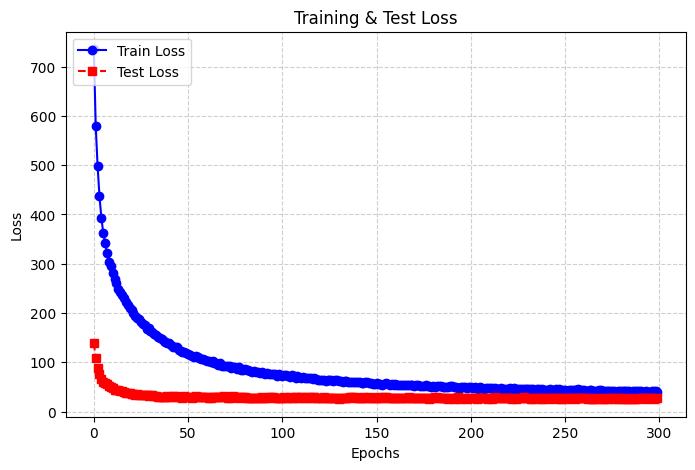

In [36]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(train_loss_history, label="Train Loss", marker='o', linestyle='-', color='blue')
ax1.plot(test_loss_history, label="Test Loss", marker='s', linestyle='--', color='red')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training & Test Loss")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.grid(True, linestyle='--', alpha=0.6)

plt.show()

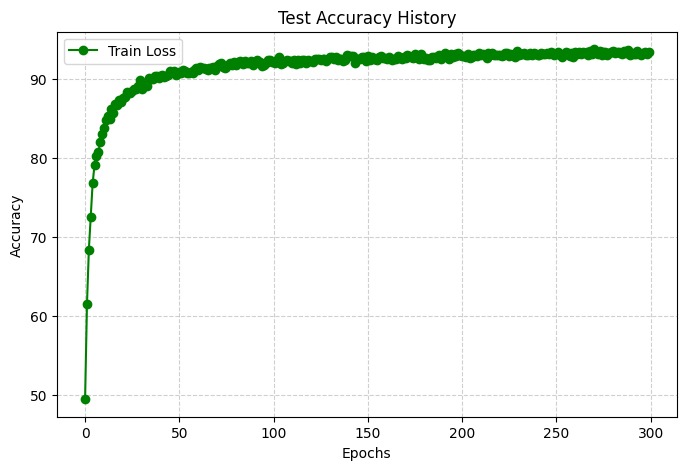

In [35]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(accuracy_history, label="Train Loss", marker='o', linestyle='-', color='green')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Test Accuracy History")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

ax1.grid(True, linestyle='--', alpha=0.6)

plt.show()